In [ ]:
import pandas as pd
pd.set_option("display.max_columns", 100)
import numpy as np
np.set_printoptions(suppress=True)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Any, Union
import pickle

In [ ]:
IN_CSV_DATA = Path().cwd().parent.parent / "data/4_data_split"
IN_MODEL_DATA = Path().cwd().parent.parent / "data/5_models"

In [ ]:
df_train_prepped = pd.read_csv(IN_CSV_DATA/'prepared_train.csv')
df_test_prepped = pd.read_csv(IN_CSV_DATA/'prepared_test.csv')
df_train = pd.read_csv(IN_CSV_DATA/'ride_summary_train.csv')
df_test = pd.read_csv(IN_CSV_DATA/'ride_summary_test.csv')

In [ ]:
numerical_feature_cols = ['total_distance_mi','total_weight_lbs','avg_cruising_speed', 'log_hours_since_last_ride',
                            'active_time_ratio', 'avg_climb_rate', 'distance_training_intensity','prior_training_load']
categorical_feature_cols = []#['year']
feature_cols = numerical_feature_cols + categorical_feature_cols

target_cols = ['best_power_4s', 'best_power_5s',
                'best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                'best_power_40m', 'best_power_1h', 'best_power_2h']

In [ ]:
X_train, y_train = df_train[feature_cols].values, df_train[target_cols].values
X_test, y_test = df_test[feature_cols].values, df_test[target_cols].values

## Choosing Test Rides to View

In [ ]:
ride1 = df_test.loc[df_test['ride_id']=='0x66b8afe9',:] # longer, yet faster training ride
ride1_index = ride1.index.values[0]
X_ride1, y_ride1 = df_test_prepped.loc[ride1_index, feature_cols].values.reshape(-1,1), df_test_prepped.loc[ride1_index, target_cols].values.reshape(-1,1)
print(ride1_index)
ride1

In [ ]:
ride2 = df_test.loc[df_test['ride_id']=='0x66a663d9',:] # medium length, but slower training ride
ride2_index = ride2.index.values[0]
X_ride2, y_ride2 = df_test_prepped.loc[ride2_index, feature_cols].values.reshape(-1,1), df_test_prepped.loc[ride2_index, target_cols].values.reshape(-1,1)
print(ride2_index)
ride2

In [ ]:
ride3 = df_test.loc[df_test['ride_id']=='0x67092425',:] # first day of OTET
ride3_index = ride3.index.values[0]
X_ride3, y_ride3 = df_test_prepped.loc[ride3_index, feature_cols].values.reshape(-1,1), df_test_prepped.loc[ride3_index, target_cols].values.reshape(-1,1)
print(ride3_index)
ride3

## Predict Ride Power Curves

In [ ]:
model_RC = pickle.load(open(IN_MODEL_DATA / 'lasso_reg_RegChain.pkl','rb'))

In [ ]:
y_ride1_pred = model_RC.predict(X_ride1.T)
y_ride2_pred = model_RC.predict(X_ride2.T)
y_ride3_pred = model_RC.predict(X_ride3.T)

In [ ]:
import re
def power_column_mapping() -> dict:
    power_cols = ['best_power_4s', 'best_power_5s','best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                'best_power_40m', 'best_power_1h', 'best_power_2h']
    # Create a mapping from power column names back to axis labels and values
    pattern = r'best_power_([\d]+)([smh])'
    seconds_map = {'s':1, 'm':60, 'h':60*60}
    power_col_map = dict()
    for col in power_cols:
        matched = re.match(pattern, col)
        if matched is not None:
            value, unit = matched.groups()
            power_col_map[col] = {'label':value+unit,'duration':int(value)*seconds_map[unit]}
    return power_col_map

In [ ]:
# Make a function to assemble the power curves into a plottable, single dataframe
def assemble_ride_curves(power_cols, y_true, y_pred):
    y_true_list = list(y_true.T[0])
    y_pred_list = list(y_pred[0])

    power_col_map = power_column_mapping()
    data_true = [{'ride_id':'Actual','duration':power_col_map[col]['duration'],'duration_label':power_col_map[col]['label'],'best_power':y} 
                 for col, y in zip(power_cols, y_true_list)]
    data_pred = [{'ride_id':'Predicted','duration':power_col_map[col]['duration'],'duration_label':power_col_map[col]['label'],'best_power':y} 
                 for col, y in zip(power_cols, y_pred_list)]
    df_compare = pd.concat([pd.DataFrame(data_true), pd.DataFrame(data_pred)], ignore_index=True)
    return df_compare

In [ ]:
df_compare1 = assemble_ride_curves(target_cols, y_ride1, y_ride1_pred)
df_compare2 = assemble_ride_curves(target_cols, y_ride2, y_ride2_pred)
df_compare3 = assemble_ride_curves(target_cols, y_ride3, y_ride3_pred)

# Plotting Ride Power Curves

In [ ]:
def get_top_cyclists_power_curve() -> pd.DataFrame:
    power_col_map = power_column_mapping()
    # top 1% of cyclists, ref: https://www.cyclinganalytics.com/blog/2018/06/how-does-your-cycling-power-output-compare
    top_cyclist_powers = {'best_power_4s':1650, 'best_power_5s':1500,'best_power_10s':1375, 'best_power_20s':1200, 'best_power_30s':1000, 'best_power_1m':775,
                        'best_power_2m':600, 'best_power_3m':560, 'best_power_4m':535, 'best_power_5m':510,
                        'best_power_6m':500, 'best_power_10m':490, 'best_power_20m':460, 'best_power_30m':420,
                        'best_power_40m':375, 'best_power_1h':360}
    data = [{'duration':power_col_map[col]['duration'], 'best_power':top_cyclist_powers[col]} for col in top_cyclist_powers.keys()]
    df_pwr_top = pd.DataFrame(data)
    return df_pwr_top

In [ ]:
def plot_summary_power_curves(df_pwrs:pd.DataFrame, figsize:tuple=(12,4), color_by:str='ride_id', alpha:float=0.8, ylims:list[float]=None,
                              logscale_base:int=10, title:str='Best Ride Efforts Power Curve', show_best_cyclist_curve:bool=True,
                              show_ride_id_labels:bool=False):
    ########################################################################
    # Create the Figure
    fig, ax = plt.subplots(1,1, figsize=figsize)

    # For each ride, plot its power curve
    plot_kwargs = dict(data=df_pwrs, x='duration', y='best_power', ax=ax, alpha=alpha,legend=False, hue=color_by)
    if color_by!='ride_id':
        plot_kwargs['legend']=True
        plot_kwargs['palette']='tab10'
    else:
        if show_ride_id_labels:
            plot_kwargs['legend']=True
    _ = sns.lineplot(**plot_kwargs)
    plot_kwargs['legend']=False # do not record dots in the legend
    _ = sns.scatterplot(**plot_kwargs)
    

    if show_best_cyclist_curve:
        df_pwr_top = get_top_cyclists_power_curve()
        _ = ax.plot(df_pwr_top['duration'],df_pwr_top['best_power'], alpha=0.8, c='red', linestyle='--')
        _ = ax.scatter(df_pwr_top['duration'],df_pwr_top['best_power'],label='Top 99% Cyclist', alpha=0.8, marker='d', c='red', linewidths=2)
        _ = plt.legend(loc='best')
    

    ########################################################################
    # Set the axes up for plotting
    def forward(x):
        return np.log10(x) / np.log10(logscale_base)

    def inverse(x):
        return logscale_base**x
    
    if logscale_base==10:
        _ = ax.set_xscale('log')
    else:
        _ = ax.set_xscale('function', functions=(forward,inverse))

    power_col_map = power_column_mapping()
    _ = plt.xticks(ticks=[col['duration'] for col in power_col_map.values()], 
                   labels=[col['label'] for col in power_col_map.values()], rotation=45)
    _ = plt.grid()
    _ = ax.set_axisbelow(True)
    _ = plt.xlabel('Effort Time Duration', fontsize=14)
    _ = plt.ylabel('Maximum Effort Power (W)', fontsize=14)
    _ = plt.title(title, fontsize=18)
    _ = plt.legend(bbox_to_anchor=(1.025, 1), loc='upper left')
    _ = plt.tight_layout()
    if ylims is not None:
        _ = plt.ylim(ylims)

In [ ]:
plot_summary_power_curves(df_compare1, show_best_cyclist_curve=False, show_ride_id_labels=True)

In [ ]:
plot_summary_power_curves(df_compare2, show_best_cyclist_curve=False, show_ride_id_labels=True)

In [ ]:
plot_summary_power_curves(df_compare3, show_best_cyclist_curve=False, show_ride_id_labels=True)

# Generic Viewer

In [30]:
def generate_kth_ride_comparison(df_summary, df_summary_prepped, index_k, feature_cols, target_cols, model):
    ridek = df_test.loc[index_k,:] # longer, yet faster training ride
    X_ridek, y_ridek = df_summary_prepped.loc[index_k, feature_cols].values.reshape(-1,1), df_summary_prepped.loc[index_k, target_cols].values.reshape(-1,1)
    print(ridek[feature_cols])

    y_ridek_pred = model.predict(X_ridek.T)
    df_comparek = assemble_ride_curves(target_cols, y_ridek, y_ridek_pred)
    return df_comparek

total_distance_mi              10.536984
total_weight_lbs                     235
avg_cruising_speed             16.893319
log_hours_since_last_ride        1.61306
active_time_ratio               0.969224
avg_climb_rate                  6.655911
distance_training_intensity     0.563656
prior_training_load             0.993953
Name: 1, dtype: object


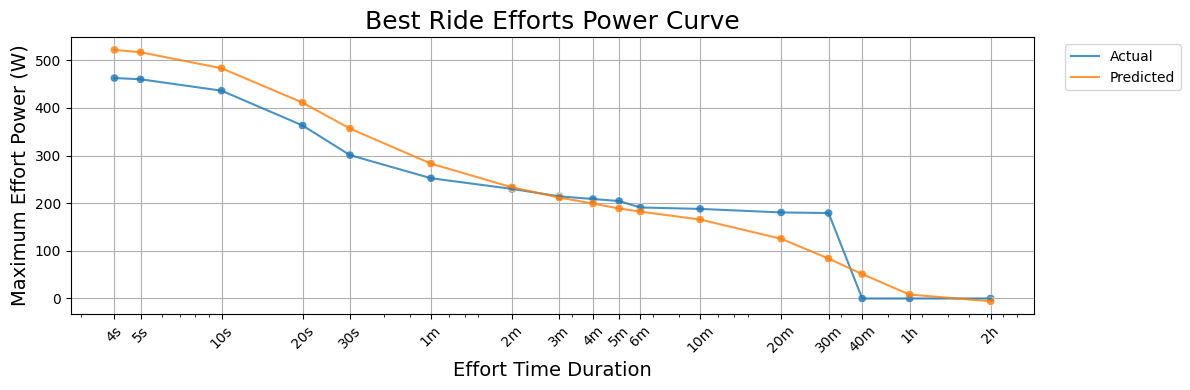

In [33]:
INDEX_K = 1
df_compare = generate_kth_ride_comparison(df_test, df_test_prepped, INDEX_K, feature_cols, target_cols, model_RC)
plot_summary_power_curves(df_compare, show_best_cyclist_curve=False, show_ride_id_labels=True)

total_distance_mi              10.265013
total_weight_lbs                     235
avg_cruising_speed              16.51023
log_hours_since_last_ride      -1.110698
active_time_ratio               0.952971
avg_climb_rate                  5.493357
distance_training_intensity     0.549108
prior_training_load             1.544166
Name: 2, dtype: object


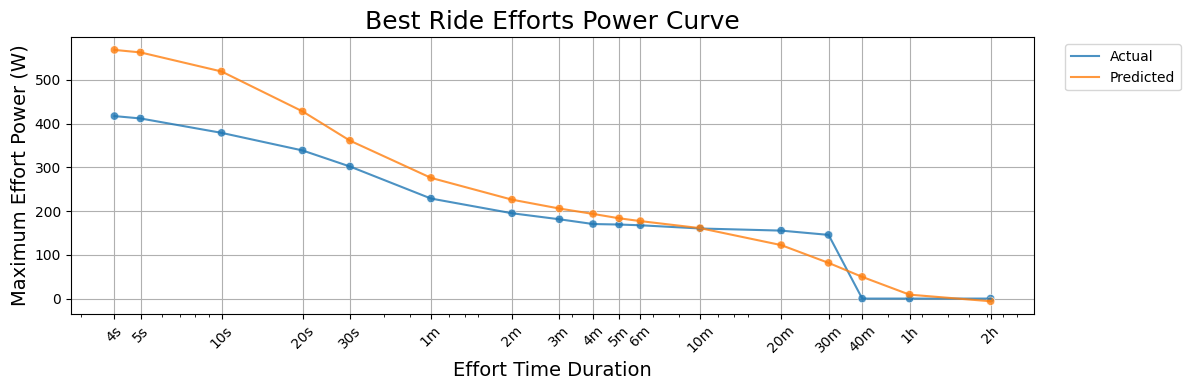

In [34]:
INDEX_K = 2
df_compare = generate_kth_ride_comparison(df_test, df_test_prepped, INDEX_K, feature_cols, target_cols, model_RC)
plot_summary_power_curves(df_compare, show_best_cyclist_curve=False, show_ride_id_labels=True)

total_distance_mi              12.253029
total_weight_lbs                     235
avg_cruising_speed             16.461781
log_hours_since_last_ride       1.610459
active_time_ratio               0.907064
avg_climb_rate                   4.86754
distance_training_intensity     0.305655
prior_training_load             0.733224
Name: 5, dtype: object


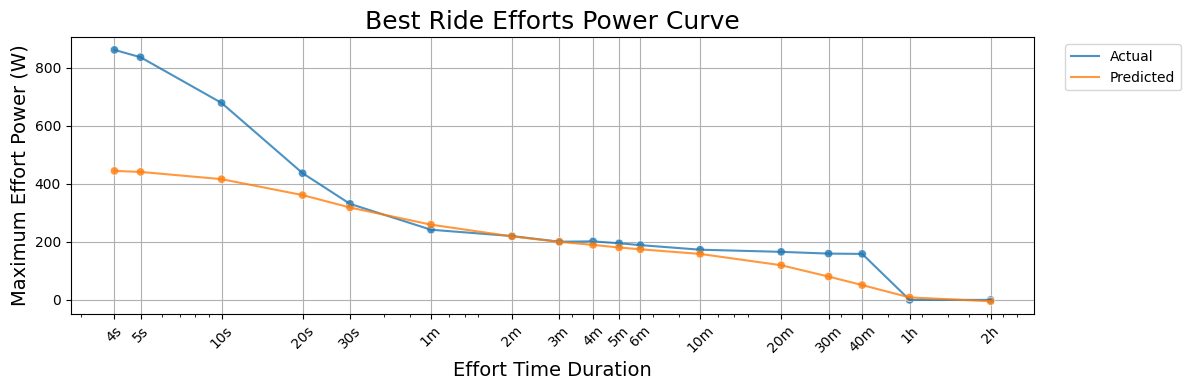

In [ ]:
INDEX_K = 5
df_compare = generate_kth_ride_comparison(df_test, df_test_prepped, INDEX_K, feature_cols, target_cols, model_RC)
plot_summary_power_curves(df_compare, show_best_cyclist_curve=False, show_ride_id_labels=True)

total_distance_mi              10.929591
total_weight_lbs                     235
avg_cruising_speed             16.610909
log_hours_since_last_ride       1.913932
active_time_ratio               0.862132
avg_climb_rate                  5.599387
distance_training_intensity     0.272642
prior_training_load             0.237705
Name: 6, dtype: object


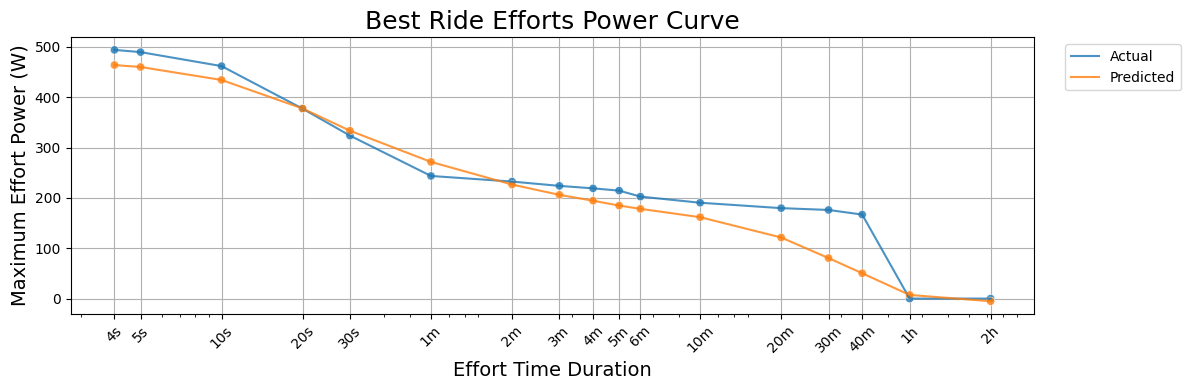

In [38]:
INDEX_K = 6
df_compare = generate_kth_ride_comparison(df_test, df_test_prepped, INDEX_K, feature_cols, target_cols, model_RC)
plot_summary_power_curves(df_compare, show_best_cyclist_curve=False, show_ride_id_labels=True)

total_distance_mi              10.878084
total_weight_lbs                     235
avg_cruising_speed             13.916211
log_hours_since_last_ride      -0.327389
active_time_ratio               0.855953
avg_climb_rate                  3.490275
distance_training_intensity     0.271357
prior_training_load             0.502919
Name: 7, dtype: object


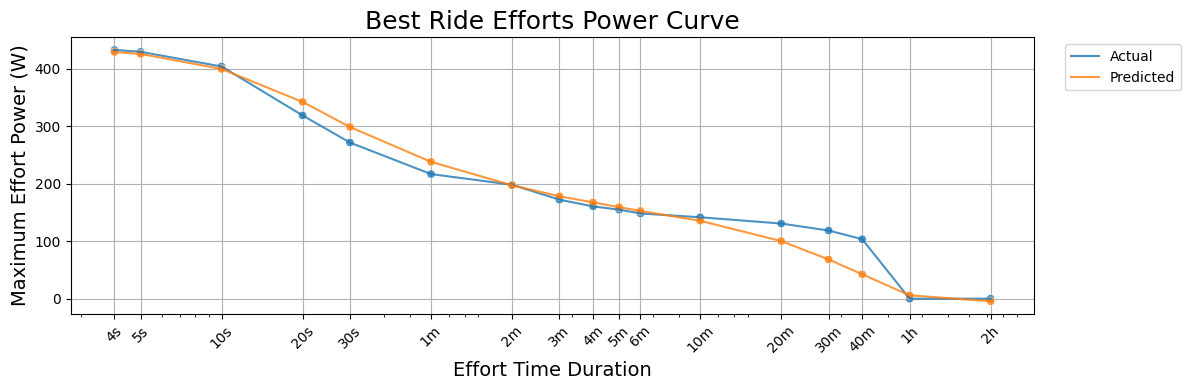

In [39]:
INDEX_K = 7
df_compare = generate_kth_ride_comparison(df_test, df_test_prepped, INDEX_K, feature_cols, target_cols, model_RC)
plot_summary_power_curves(df_compare, show_best_cyclist_curve=False, show_ride_id_labels=True)